# Profile Based Information Retrieval System
### Carlos Alcoba, Javier Jiménez, Javier Pozo

## Install and import libraries

In [23]:
# pip install -r requirements.txt

#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

In [24]:
#for dataframes and plots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

#for text vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument 

## Import the dataset

In [25]:
from sklearn.datasets import fetch_20newsgroups

def twenty_newsgroup_to_csv():
    newsgroups_train = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame( newsgroups_train.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out['date'] = pd.to_datetime('now')
    out.to_csv('20_newsgroup.csv')
    
twenty_newsgroup_to_csv()

In [26]:
# Create a dataframe
data = pd.read_csv('20_newsgroup.csv', index_col = 0)

# Select only 5 classes
class_mask = data["target"].isin([7,9,13,18,19])
data = data[class_mask]
data.head()

,text,target,title,date
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,2022-04-08 09:14:18.015754
10,the blood of the lamb.\n\nThis will be a hard ...,19,talk.religion.misc,2022-04-08 09:14:18.015754
12,930418\n\nDo what thou wilt shall be the whole...,19,talk.religion.misc,2022-04-08 09:14:18.015754
40,\n\nNo. Zeno's paradox is resolved by showing...,19,talk.religion.misc,2022-04-08 09:14:18.015754
58,"\nDefinitely, J.R. ""Bob"" Dobbs, numero uno, to...",19,talk.religion.misc,2022-04-08 09:14:18.015754


In [27]:
#Split the dataset into training and testing ones
df_train, df_test = train_test_split(data,test_size=0.2,shuffle=True)

## Exploratory data analysis

rec.sport.baseball    803
rec.autos             795
sci.med               780
talk.politics.misc    629
talk.religion.misc    494
Name: title, dtype: int64


C:\Users\javij\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Number of douments in each class')]

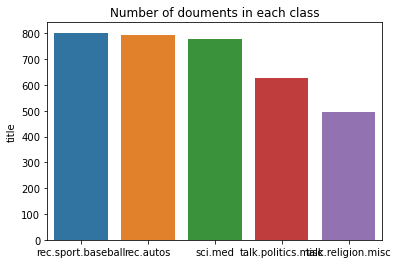

In [28]:
#Count the number of douments in each class
x=df_train['title'].value_counts()
print(x)
sns.barplot(x.index,x).set(title="Number of douments in each class")

In [29]:
# Find NaN values
df_test.isna().sum()

text      21
target     0
title      0
date       0
dtype: int64

In [30]:
# Drop NaN values
df_train = df_train.dropna()
df_test = df_test.dropna()
# Check for it
df_test.isna().sum()

text      0
target    0
title     0
date      0
dtype: int64

In [31]:
# Some word count examples
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['target']==9]['word_count'].mean()) # Baseball posts
print(df_test[df_test['target']==9]['word_count'].mean()) # Baseball posts

128.87051282051283
127.09139784946237


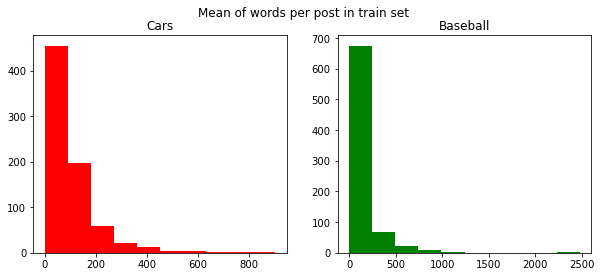

In [32]:
# Some Word-Count plots examples
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=df_train[df_train['target']==7]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Cars')
train_words=df_train[df_train['target']==9]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Baseball')
fig.suptitle('Mean of words per post in train set')
plt.show()

In [33]:
# Some character count examplesS
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['target']==9]['char_count'].mean()) # Baseball posts
print(df_test[df_test['target']==9]['char_count'].mean()) # Baseball posts


749.3897435897436
728.9301075268817


## Text processing

In [34]:
# Convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

 
# Remove Stopwords
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

# Lemmatize:
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
        
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [35]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

# Obtain clean text columns
df_train['clean_text'] = df_train['text'].apply(lambda x: finalpreprocess(x))
df_train.head()
df_test['clean_text'] = df_test['text'].apply(lambda x: finalpreprocess(x))


In [44]:
# Obtain final train and test vectors 
X_train, y_train = df_train["clean_text"], df_train["target"]
X_test, y_test = df_test["clean_text"], df_test["target"]


# Tokenize sentences to future applications
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  
X_test_tok= [nltk.word_tokenize(i) for i in X_test]

## Text vectorizers

In [37]:
#TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
#Obtain vectors via TF-IDF
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [38]:
# Doc2Vec vectorizer
train_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(df_train.clean_text)]


#build the model
model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs = 40)
#build vocab
model.build_vocab(train_docs)
#train model
model.train(train_docs, total_examples=model.corpus_count, epochs=model.epochs)

In [39]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents])
    return targets, regressors

In [40]:
# Obtain vectors via doc2vec
y_train_w2v, x_train_w2v = vec_for_learning(model, train_docs)


## Train different models

In [42]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, balanced_accuracy_score

svm_acc = accuracy_score(y_test, y_predict)
svm_f1 = f1_score(y_test, y_predict, average ='weighted')
svm_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Logistic Regression(tf-idf) is {svm_acc} \n")
print(f"Test Balanced Accuracy of Logistic Regression(tf-idf) is {svm_bacc} \n")
print(f"Test F1-score weighted of Logistic Regression(tf-idf) is {svm_f1} \n")

              precision    recall  f1-score   support

           7       0.91      0.91      0.91       189
           9       0.93      0.93      0.93       186
          13       0.93      0.94      0.93       206
          18       0.82      0.83      0.82       144
          19       0.82      0.78      0.80       130

    accuracy                           0.89       855
   macro avg       0.88      0.88      0.88       855
weighted avg       0.89      0.89      0.89       855

Confusion Matrix: [[172   4   6   6   1]
 [  7 173   1   3   2]
 [  2   1 194   3   6]
 [  4   3   4 119  14]
 [  5   5   4  14 102]]
Test Accuracy of Logistic Regression(tf-idf) is 0.8888888888888888 

Test Balanced Accuracy of Logistic Regression(tf-idf) is 0.8785824566508875 

Test F1-score weighted of Logistic Regression(tf-idf) is 0.8885754383602851 



In [43]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  
#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_test_vectors_tfidf)
y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))

svm_acc = accuracy_score(y_test, y_predict)
svm_f1 = f1_score(y_test, y_predict, average ='weighted')
svm_bacc = balanced_accuracy_score(y_test, y_predict)

print(f"Test Accuracy of Naive Bayes(tf-idf) is {svm_acc} \n")
print(f"Test Balanced Accuracy of Naive Bayes(tf-idf) is {svm_bacc} \n")
print(f"Test F1-score weighted of Naive Bayes(tf-idf) is {svm_f1} \n")

              precision    recall  f1-score   support

           7       0.93      0.90      0.92       189
           9       0.87      0.97      0.92       186
          13       0.87      0.96      0.91       206
          18       0.74      0.87      0.80       144
          19       0.94      0.51      0.66       130

    accuracy                           0.87       855
   macro avg       0.87      0.84      0.84       855
weighted avg       0.87      0.87      0.86       855

Confusion Matrix: [[171   6   5   7   0]
 [  0 181   3   2   0]
 [  1   4 197   2   2]
 [  4   6   7 125   2]
 [  7  10  14  33  66]]
Test Accuracy of Naive Bayes(tf-idf) is 0.8654970760233918 

Test Balanced Accuracy of Naive Bayes(tf-idf) is 0.8419877454382622 

Test F1-score weighted of Naive Bayes(tf-idf) is 0.8582244594870905 

